<a href="https://colab.research.google.com/github/Flychuban/Tyres-Condition/blob/main/TyreCondition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import tensorflow as tf
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
train_path = Path('/content/drive/MyDrive/TyreConditionPrediction/data/Tire Textures/training_data')
test_path = Path('/content/drive/MyDrive/TyreConditionPrediction/data/Tire Textures/testing_data')
RANDOM_SEED = 10
EPOCHS = 50
BATCH_SIZE = 16

In [25]:
labels = os.listdir(train_path)
labels

['normal', 'cracked']

Let's make our dataset

In [26]:
def process_data(data):
  path = Path(data)
  filepaths = list(path.glob(r'*/*.jpg'))
  labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))#Separating the label from filepath and storing it
  df1 = pd.Series(filepaths, name='filepaths').astype(str)
  df2 = pd.Series(labels, name='labels')
  df = pd.concat([df1, df2], axis=1)
  return df

In [65]:
train_data = process_data(train_path)
test_data = process_data(test_path)
train_data

,filepaths,labels
0,/content/drive/MyDrive/TyreConditionPrediction...,normal
1,/content/drive/MyDrive/TyreConditionPrediction...,normal
2,/content/drive/MyDrive/TyreConditionPrediction...,normal
3,/content/drive/MyDrive/TyreConditionPrediction...,normal
4,/content/drive/MyDrive/TyreConditionPrediction...,normal
...,...,...
698,/content/drive/MyDrive/TyreConditionPrediction...,cracked
699,/content/drive/MyDrive/TyreConditionPrediction...,cracked
700,/content/drive/MyDrive/TyreConditionPrediction...,cracked
701,/content/drive/MyDrive/TyreConditionPrediction...,cracked


In [80]:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    validation_split=0.5)

In [81]:
train_images = train_generator.flow_from_dataframe(dataframe=train_data,
                                                   target_size=(224, 224),
                                                   batch_size = BATCH_SIZE,
                                                   x_col='filepaths',
                                                   y_col='labels',
                                                   class_mode='binary',
                                                   random_seed=RANDOM_SEED)

test_images = test_generator.flow_from_dataframe(dataframe=test_data,
                                                 target_size=(224, 224),
                                                 batch_size=BATCH_SIZE,
                                                 x_col='filepaths',
                                                 y_col = 'labels',
                                                 class_mode='binary',
                                                 random_seed = RANDOM_SEED,
                                                 subset='training'
                                                 )

val_images = test_generator.flow_from_dataframe(dataframe=test_data,
                                                   target_size=(224, 224),
                                                   batch_size = BATCH_SIZE,
                                                   x_col='filepaths',
                                                   y_col='labels',
                                                   class_mode='binary',
                                                   random_seed=RANDOM_SEED,
                                                   subset="validation"
                                                )


Found 703 validated image filenames belonging to 2 classes.
Found 163 validated image filenames belonging to 2 classes.
Found 162 validated image filenames belonging to 2 classes.


Build the model

In [82]:
pretrained_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights = 'imagenet',
    pooling='max'
)

In [83]:
pretrained_model.trainable = False # we make this cuz w don't train again the big model

In [84]:
inputs = pretrained_model.input

new_layer = Dense(30, activation='relu')(pretrained_model.output)
Dropout(0.3)
new_layer = Dense(60, activation='relu')(new_layer)
Dropout(0.5)
new_layer = Dense(120, activation ='relu')(new_layer)

outputs = Dense(1, activation = 'sigmoid')(new_layer)

In [85]:
model = Model(inputs=inputs, outputs=outputs)

In [86]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
)

In [87]:
early_stop = EarlyStopping(monitor='val_loss',patience=3, restore_best_weights=True)

Training

In [88]:
history = model.fit(train_images,
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_images),
                    validation_data=val_images,
                    validation_steps=len(val_images),
                    callbacks=[early_stop]
                    )

Epoch 1/50
44/44 [==============================] - 207s 5s/step - loss: 0.4771 - accuracy: 0.7696 - val_loss: 0.4097 - val_accuracy: 0.8457
Epoch 2/50
44/44 [==============================] - 197s 4s/step - loss: 0.2564 - accuracy: 0.9047 - val_loss: 0.3657 - val_accuracy: 0.8519
Epoch 3/50
44/44 [==============================] - 201s 5s/step - loss: 0.2314 - accuracy: 0.9132 - val_loss: 0.3555 - val_accuracy: 0.8827
Epoch 4/50
44/44 [==============================] - 197s 4s/step - loss: 0.2099 - accuracy: 0.9275 - val_loss: 0.3045 - val_accuracy: 0.8642
Epoch 5/50
44/44 [==============================] - 204s 5s/step - loss: 0.2068 - accuracy: 0.9260 - val_loss: 0.3858 - val_accuracy: 0.8395
Epoch 6/50
44/44 [==============================] - 199s 4s/step - loss: 0.1943 - accuracy: 0.9317 - val_loss: 0.2405 - val_accuracy: 0.8827
Epoch 7/50
44/44 [==============================] - 194s 4s/step - loss: 0.1470 - accuracy: 0.9516 - val_loss: 0.3273 - val_accuracy: 0.8765
Epoch 8/50
44

In [91]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

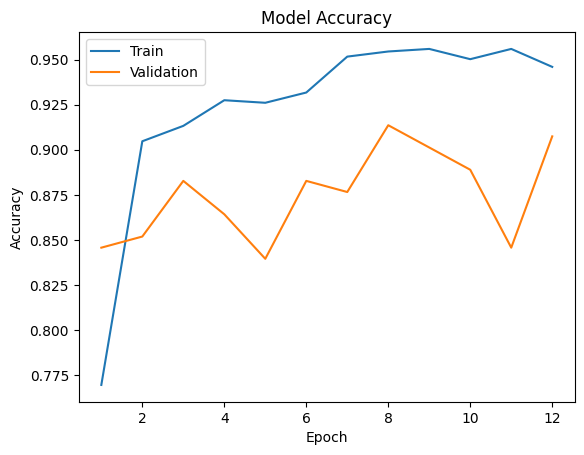

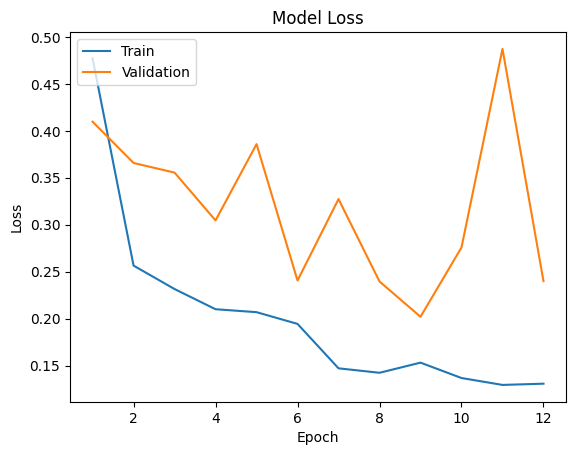

In [93]:
plotLearningCurve(history,12)

In [9]:
model.evaluate(test_images)

NameError: ignored

In [95]:
model.save("tyre_condition_model_4.h5")

In [10]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TyreConditionPrediction/tyre_condition_model_4.h5')

In [24]:
from tensorflow.keras.preprocessing import image

test_image = image.load_img('/content/drive/MyDrive/TyreConditionPrediction/tyre4_img.jpg', target_size = (224, 224)) # Get the image
transformed_image = image.img_to_array(test_image) # Transform image to array
transformed_image = np.expand_dims(transformed_image, axis=0) # Expand dims to make a batch of 1 image
prediction = model.predict(transformed_image)

print(prediction)

if prediction[0] < 0.5:
  print("This tyre HAS a problem!")
else:
  print("This tyre HASN'T problem!")

1/1 [==============================] - 0s 361ms/step
[[0.98975486]]
This tyre HASN'T problem!
